# Project Overview: 

#### Objective:
The goal of this project is to practice my analysis skills on a dataset. I will be exploring trends in nfl QB statistics over the past 5 seasons. 

#### Key Questions
1. How has the average passing yardage per game changed over the last four seasons?
2. Which quarterbacks consistently perform above the league average in touchdowns?
3. Is there a relationship between passing attempts and interceptions?

## Setup

In [1]:
# Import the neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nfl_data_py as nfl

In [2]:
#Define the timeline for the data
seasons = [2020, 2021, 2022, 2023, 2024]

In [ ]:
#Pull the data from the API 
"""This will pull the weekly data for the specified years, 
We only need to run it once. The rest of the time we can use our local copy."""

get_nfl_data = nfl.import_weekly_data(years=seasons, downcast=True) 
get_nfl_data.to_csv('nfl_weekly_data.csv', index=False)

In [3]:
# Read the data from the CSV file
nfl_df = pd.read_csv('nfl_weekly_data.csv')

In [ ]:
nfl_df

## Preparing the data


We are only interested in: 
1. QB's with over 200 attempts
2. Regular Season Stats

This will filter out any non-qb players that threw the ball on trick plays. It will also filter out any short term qb replacements that may have stepped into a game so that the starting QB can rest. We are removing these players to reduce outliers that will affect our calculations. 

In [6]:
qb_df = nfl_df[(nfl_df['position'] == 'QB') & # Only Players designated as QB
               (nfl_df['season_type']== 'REG')].copy() # Only Regular Season Games
               

We will create a new data frame that groups each player by season and adds up their stats. Then a new column for passing yards per game and passing touchdowns per game is created.

In [24]:
qb_season_stats = (
    qb_df.groupby(['season', 'player_display_name',])
    .agg(
        games_played=('week', 'nunique'),
        passing_yards=('passing_yards', 'sum'),
        passing_attempts=('attempts', 'sum'),
        completions=('completions', 'sum'),
        passing_tds=('passing_tds', 'sum'),
        interceptions=('interceptions', 'sum')
    )
    .reset_index()
)

#Filter out players with less than 200 attemps passing
qb_season_stats = qb_season_stats[qb_season_stats['passing_attempts']>= 200]

# Calculate how the average passing yards per game. 
qb_season_stats['passing_yards_per_game'] = (qb_season_stats['passing_yards'] / qb_season_stats['games_played']).round(2)

# Calculate the average amound of TD's thrown per game. 
qb_season_stats['touchdowns_per_game'] = (qb_season_stats['passing_tds']/ qb_season_stats['games_played']).round(2)


In [25]:
qb_season_stats

,season,player_display_name,games_played,passing_yards,passing_attempts,completions,passing_tds,interceptions,passing_yards_per_game,touchdowns_per_game
1,2020,Aaron Rodgers,16,4299.0,526,372,48,5.0,268.69,3.00
2,2020,Alex Smith,8,1582.0,252,168,6,8.0,197.75,0.75
3,2020,Andy Dalton,11,2170.0,333,216,14,8.0,197.27,1.27
4,2020,Baker Mayfield,16,3563.0,486,305,26,8.0,222.69,1.62
6,2020,Ben Roethlisberger,15,3803.0,608,399,33,10.0,253.53,2.20
...,...,...,...,...,...,...,...,...,...,...
391,2024,Sam Darnold,17,4319.0,545,361,35,12.0,254.06,2.06
394,2024,Spencer Rattler,7,1317.0,228,130,4,5.0,188.14,0.57
399,2024,Trevor Lawrence,10,2045.0,284,172,11,7.0,204.50,1.10
401,2024,Tua Tagovailoa,11,2867.0,399,291,19,7.0,260.64,1.73


## Analysis

### Q1: How has the average passing yardage per game changed over the last four seasons?

In [ ]:
# Calculate league average per season, rounded to the 2nd decimal place.
league_avg = qb_season_stats.groupby('season').agg(
    avg_passing_yards_per_game=('passing_yards_per_game', 'mean')
).round(2).reset_index()

In [ ]:
league_avg

Graphing the League average over the past 5 seasons 

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=league_avg, x='season', y='avg_passing_yards_per_game', marker='o')
plt.title('League Average Passing Yards per Game (2020-2024)')
plt.xlabel('Season')
plt.ylabel('Yards per Game')
plt.grid(True)
plt.show()

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))

# BAR PLOT
ax = sns.barplot(data=league_avg, x='season', y='avg_passing_yards_per_game')
#Style the chart
plt.title('League Average Passing Yards per Game (2020-2024)')
plt.xlabel('Season')
plt.ylabel('Yards per Game')
plt.grid(False, axis='y')
plt.margins(y=0.2) # Add some space above the top of the bars. 
plt.xticks(rotation=45)

# VALUES ON TOP OF BARS
for i, row in league_avg.iterrows():
    ax.plot(i, row['avg_passing_yards_per_game'], 'black', marker='o')
    ax.text(i, row['avg_passing_yards_per_game'] + 4, 
            f"{row['avg_passing_yards_per_game']}", ha= 'center', fontsize=10,)


plt.show()

#### How has the average passing yardage per game changed over the last four seasons?

Average passing yards per game have decreased year over year for the past 5 years. 

### Q2: Which quarterbacks consistently perform above the league average in touchdowns?

In [9]:
# Calculate league average touchdowns per game
league_avg_td = qb_season_stats.groupby('season')['touchdowns_per_game'].mean().reset_index()

league_avg_td

,season,touchdowns_per_game
0,2020,1.608333
1,2021,1.463636
2,2022,1.385758
3,2023,1.364286
4,2024,1.374103


In [20]:
# Identify QBs above average each season
consistent_qbs = []
for year in seasons:
    year_data = qb_season_stats[qb_season_stats['season'] == year]
    avg_td = league_avg_td[league_avg_td['season'] == year]['touchdowns_per_game'].values[0]
    above_avg = year_data[year_data['touchdowns_per_game'] > avg_td]
    consistent_qbs.append(set(above_avg['player_display_name']))
    

print(consistent_qbs)

[{'Baker Mayfield', 'Derek Carr', 'Matthew Stafford', 'Deshaun Watson', 'Lamar Jackson', 'Ben Roethlisberger', 'Russell Wilson', 'Dak Prescott', 'Kirk Cousins', 'Gardner Minshew', 'Justin Herbert', 'Aaron Rodgers', 'Matt Ryan', 'Josh Allen', 'Tom Brady', 'Ryan Tannehill', 'Kyler Murray', 'Patrick Mahomes', 'Drew Brees'}, {'Josh Allen', 'Tom Brady', 'Matthew Stafford', 'Russell Wilson', 'Kyler Murray', 'Patrick Mahomes', 'Dak Prescott', 'Kirk Cousins', 'Joe Burrow', 'Justin Herbert', 'Aaron Rodgers', 'Carson Wentz'}, {'Derek Carr', 'Josh Allen', 'Lamar Jackson', 'Jared Goff', 'Tom Brady', 'Patrick Mahomes', 'Dak Prescott', 'Jimmy Garoppolo', 'Kirk Cousins', 'Trevor Lawrence', 'Joe Burrow', 'Geno Smith', 'Jalen Hurts', 'Tua Tagovailoa', 'Justin Herbert', 'Aaron Rodgers'}, {'Baker Mayfield', 'Derek Carr', 'Josh Allen', 'Joe Flacco', 'Lamar Jackson', 'Jared Goff', 'Matthew Stafford', 'Russell Wilson', 'C.J. Stroud', 'Patrick Mahomes', 'Dak Prescott', 'Kirk Cousins', 'Tua Tagovailoa', 'Joe 

In [ ]:
# Find QBs consistent across all seasons. 
consistent_players = set.intersection(*map(set, consistent_qbs))

print(consistent_players)

{'Dak Prescott', 'Josh Allen', 'Patrick Mahomes'}


In [ ]:
# Generate report
consistency_report = qb_season_stats[qb_season_stats['player_display_name'].isin(consistent_players)][
    ['player_display_name', 'season', 'touchdowns_per_game']
].sort_values(['player_display_name', 'season'])


In [19]:
print(consistency_report)

    player_display_name  season  touchdowns_per_game
19         Dak Prescott    2020                 1.80
98         Dak Prescott    2021                 2.31
182        Dak Prescott    2022                 1.92
265        Dak Prescott    2023                 2.12
344        Dak Prescott    2024                 1.38
43           Josh Allen    2020                 2.31
120          Josh Allen    2021                 2.12
204          Josh Allen    2022                 2.19
288          Josh Allen    2023                 1.71
369          Josh Allen    2024                 1.75
64      Patrick Mahomes    2020                 2.53
144     Patrick Mahomes    2021                 2.18
227     Patrick Mahomes    2022                 2.41
310     Patrick Mahomes    2023                 1.69
389     Patrick Mahomes    2024                 1.62


Interpretation?? PUT ANSWER HERE

### Q3: Is there a relationship between passing attempts and interceptions?

Correlation Coefficient:  0.5030046153546381



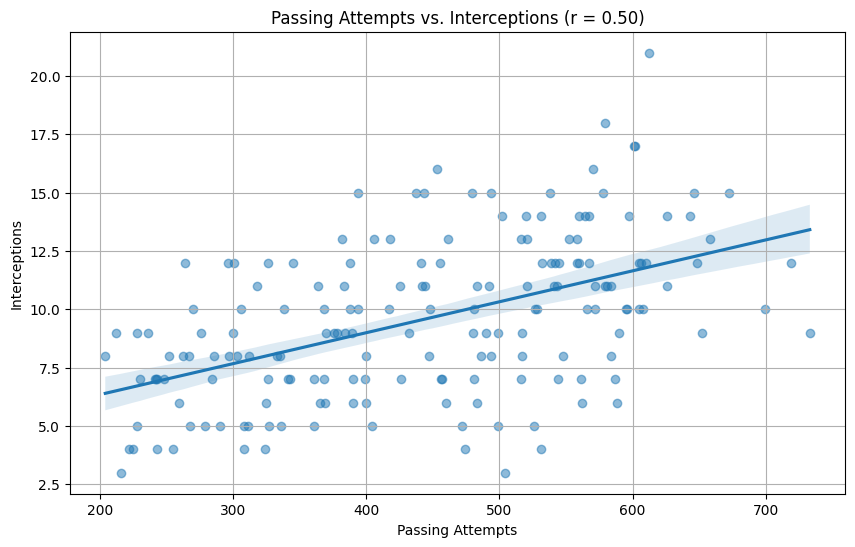

In [30]:
# Calculate correlation
correlation = qb_season_stats['passing_attempts'].corr(qb_season_stats['interceptions'])

print("Correlation Coefficient: ", correlation)
print()

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=qb_season_stats, x='passing_attempts', y='interceptions', scatter_kws={'alpha':0.5})
plt.title(f'Passing Attempts vs. Interceptions (r = {correlation:.2f})')
plt.xlabel('Passing Attempts')
plt.ylabel('Interceptions')
plt.grid(True)
plt.show()


**Intepretation:**

Trend Line:
The correlation coefficient r=0.503 means that there is a moderate positive relationship between passing attempts and interceptions. This suggest that Quarterbacks who throw more passes tend to throw more interceptions. 

Scatter Plot: 
The scatter plot shows that some quarterbacks throw a lot but keep their INT's relatively low, while the reverse is also true. That makes sense why we only find that there is a moderatae relationship, and not a strong one. The spread of dots around the line shows there is significant variation, which would imply that there are more factors other than passing volume, that play into a QB's interception total. 

Conclusion: WBile throwing more passes generally leads to more interceptions, QB's skill, decision-making, and other factors play an important roles in determining interception rates. 




0.5030046153546381
